In [2]:
! pip install pandas nltk beautifulsoup4 contractions tqdm datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from datasets import load_dataset
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
from tqdm import tqdm

# 确保下载所需的 NLTK 资源
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# load dataset
df = pd.read_csv('/content/preprocessed_ag_news_train.csv')
pd.set_option('display.max_colwidth', None)
df

,text,label,processed_text
0,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",2,wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green
1,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",2,carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market
2,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,2,oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums
3,"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",2,iraq halt oil export main southern pipeline reuters reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday
4,"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",2,oil price soar alltime record posing new menace u economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election
...,...,...,...
119518,"Pakistan's Musharraf Says Won't Quit as Army Chief KARACHI (Reuters) - Pakistani President Pervez Musharraf has said he will stay on as army chief, reneging on a pledge to quit the powerful post by the end of the year.",0,pakistan musharraf say quit army chief karachi reuters pakistani president pervez musharraf said stay army chief reneging pledge quit powerful post end year
119519,"Renteria signing a top-shelf deal Red Sox general manager Theo Epstein acknowledged Edgar Renteria was more a luxury for the 2005 Red Sox than a necessity. But there's nothing wrong with getting the keys to a BMW, and that's what the four-time All-Star and two-time Gold Glover is in the eyes of the Red Sox.",1,renteria signing topshelf deal red sox general manager theo epstein acknowledged edgar renteria luxury red sox necessity nothing wrong getting key bmw fourtime allstar twotime gold glover eye red sox
119520,"Saban not going to Dolphins yet The Miami Dolphins will put their courtship of LSU coach Nick Saban on hold to comply with the NFL's hiring policy by interviewing at least one minority candidate, a team source told The Associated Press last night.",1,saban going dolphin yet miami dolphin put courtship lsu coach nick saban hold comply nfls hiring policy interviewing least one minority candidate team source told associated press last night
119521,"Today's NFL games PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: Steelers by 10. Records: Steelers 12-1, Giants 5-8. Vs. spread: Steelers 10-1-2, Giants 5-8. Series: Giants lead, 43-27-3. Comments: Think the Giants knew Ben Roethlisberger was available on draft day when they broke the bank and traded for Eli Manning? . . . All Big Ben has done this year is complete ...",1,today nfl game pittsburgh ny giant time pm line steelers record steelers giant v spread steelers giant series giant lead comment think giant k

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119523 entries, 0 to 119522
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            119523 non-null  object
 1   label           119523 non-null  int64 
 2   processed_text  119523 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [7]:
# dataset label
df['label'].value_counts()

,count
label,
1,29920
0,29914
2,29859
3,29830


In [8]:
true_labels = df['label'].values
review = df['processed_text'].values

In [13]:
# 预处理函数
def preprocess_text(text):
    # 去除HTML标签
    text = BeautifulSoup(text, "html.parser").get_text()

    # 扩展缩写
    text = contractions.fix(text)

    # 去除特殊字符和数字
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 转为小写
    text = text.lower()

    # 分词
    tokens = word_tokenize(text)

    # 去除停用词
    tokens = [word for word in tokens if word not in stop_words]

    # 词形还原
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 去除多余的空格并重组文本
    text = ' '.join(tokens)

    return text

# 定义停用词和词形还原工具
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
# 预处理关键词
def preprocess_keywords(keywords):
    processed_keywords = {}
    for category, words in keywords.items():
        processed_words = [preprocess_text(word) for word in words]
        processed_keywords[category] = processed_words
    return processed_keywords

In [9]:
# 定义原始关键词
raw_keywords = {
    'World': [
        'world', 'international', 'country', 'countries', 'global', 'government', 'diplomatic',
        'nation', 'conflict', 'war', 'politics', 'election', 'foreign', 'policy', 'united nations',
        'trade', 'agreement', 'treaty', 'crisis', 'border', 'embassy', 'refugee', 'sanction', 'alliance'
    ],
    'Sports': [
        'sport', 'football', 'soccer', 'basketball', 'baseball', 'tennis', 'cricket', 'match', 'game',
        'player', 'team', 'coach', 'tournament', 'league', 'goal', 'score', 'olympics', 'medal',
        'champion', 'athlete', 'race', 'competition', 'win', 'loss', 'victory', 'defeat'
    ],
    'Business': [
        'business', 'market', 'company', 'financial', 'economy', 'stock', 'investment', 'profit',
        'loss', 'revenue', 'trade', 'industry', 'share', 'corporate', 'merger', 'acquisition', 'bank',
        'finance', 'banking', 'capital', 'billion', 'million', 'tax', 'regulation', 'marketplace',
        'inflation', 'export', 'import', 'entrepreneur', 'startup', 'commerce', 'sales', 'growth'
    ],
    'Sci/Tech': [
        'technology', 'science', 'tech', 'computer', 'internet', 'software', 'hardware', 'innovation',
        'research', 'data', 'AI', 'artificial intelligence', 'robot', 'machine learning', 'biology',
        'physics', 'chemistry', 'engineering', 'space', 'nasa', 'medical', 'genetic', 'climate',
        'environment', 'cyber', 'digital', 'cloud', 'network', 'mobile', 'gadget', 'device', 'app',
        'application', 'web', 'online', 'social media', 'biotech', 'renewable', 'energy', 'sustainability'
    ],
}

In [14]:
# 应用关键词预处理
keywords = preprocess_keywords(raw_keywords)

print(keywords)

{'World': ['world', 'international', 'country', 'country', 'global', 'government', 'diplomatic', 'nation', 'conflict', 'war', 'politics', 'election', 'foreign', 'policy', 'united nation', 'trade', 'agreement', 'treaty', 'crisis', 'border', 'embassy', 'refugee', 'sanction', 'alliance'], 'Sports': ['sport', 'football', 'soccer', 'basketball', 'baseball', 'tennis', 'cricket', 'match', 'game', 'player', 'team', 'coach', 'tournament', 'league', 'goal', 'score', 'olympics', 'medal', 'champion', 'athlete', 'race', 'competition', 'win', 'loss', 'victory', 'defeat'], 'Business': ['business', 'market', 'company', 'financial', 'economy', 'stock', 'investment', 'profit', 'loss', 'revenue', 'trade', 'industry', 'share', 'corporate', 'merger', 'acquisition', 'bank', 'finance', 'banking', 'capital', 'billion', 'million', 'tax', 'regulation', 'marketplace', 'inflation', 'export', 'import', 'entrepreneur', 'startup', 'commerce', 'sale', 'growth'], 'Sci/Tech': ['technology', 'science', 'tech', 'computer

In [16]:
# 类别映射
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

# 定义关键词匹配函数
def match_keywords(text):
    scores = {category: 0 for category in keywords}
    for category, words in keywords.items():
        for word in words:
            if word in text:
                scores[category] += 1
    # 返回得分最高的类别
    return max(scores, key=scores.get)

# 应用关键词匹配模型
df['predicted_label'] = df['processed_text'].apply(match_keywords)

# 评估模型
df['true_label'] = df['label'].map(label_map)
accuracy = (df['predicted_label'] == df['true_label']).mean()
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 56.81%


In [18]:
df

,text,label,processed_text,predicted_label,true_label
0,"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.",2,wall st bear claw back black reuters reuters shortsellers wall street dwindlingband ultracynics seeing green,Sports,Business
1,"Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.",2,carlyle look toward commercial aerospace reuters reuters private investment firm carlyle groupwhich reputation making welltimed occasionallycontroversial play defense industry quietly placedits bet another part market,Business,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.,2,oil economy cloud stock outlook reuters reuters soaring crude price plus worriesabout economy outlook earnings expected tohang stock market next week depth thesummer doldrums,Business,Business
3,"Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.",2,iraq halt oil export main southern pipeline reuters reuters authority halted oil exportflows main pipeline southern iraq afterintelligence showed rebel militia could strikeinfrastructure oil official said saturday,Business,Business
4,"Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections.",2,oil price soar alltime record posing new menace u economy afp afp tearaway world oil price toppling record straining wallet present new economic menace barely three month u presidential election,World,Business
...,...,...,...,...,...
119518,"Pakistan's Musharraf Says Won't Quit as Army Chief KARACHI (Reuters) - Pakistani President Pervez Musharraf has said he will stay on as army chief, reneging on a pledge to quit the powerful post by the end of the year.",0,pakistan musharraf say quit army chief karachi reuters pakistani president pervez musharraf said stay army chief reneging pledge quit powerful post end year,Sci/Tech,World
119519,"Renteria signing a top-shelf deal Red Sox general manager Theo Epstein acknowledged Edgar Renteria was more a luxury for the 2005 Red Sox than a necessity. But there's nothing wrong with getting the keys to a BMW, and that's what the four-time All-Star and two-time Gold Glover is in the eyes of the Red Sox.",1,renteria signing topshelf deal red sox general manager theo epstein acknowledged edgar renteria luxury red sox necessity nothing wrong getting key bmw fourtime allstar twotime gold glover eye red sox,World,Sports
119520,"Saban not going to Dolphins yet The Miami Dolphins will put their courtship of LSU coach Nick Saban on hold to comply with the NFL's hiring policy by interviewing at least one minority candidate, a team source told The Associated Press last night.",1,saban going dolphin yet miami dolphin put courtship lsu coach nick saban hold comply nfls hiring policy interviewing least one minority candidate team source told associated press last night,Sports,Sports
119521,"Today's NFL games PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: Steelers by 10. Records: Steelers 12-1, Giants 5-8. Vs. spread: Steelers 10-1-2, Giants 5-8. Series: Giants lead, 43-27-3. Comments: Think the Giants knew Ben Roethlisberger was available on draft day when they broke the bank and traded for Eli Manning? . . . All Big Ben has done this year

In [17]:
! pip install scikit-learn

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 生成分类报告
report = classification_report(df['true_label'], df['predicted_label'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Business       0.67      0.51      0.58     29859
    Sci/Tech       0.49      0.51      0.50     29830
      Sports       0.76      0.67      0.71     29920
       World       0.44      0.58      0.50     29914

    accuracy                           0.57    119523
   macro avg       0.59      0.57      0.57    119523
weighted avg       0.59      0.57      0.57    119523



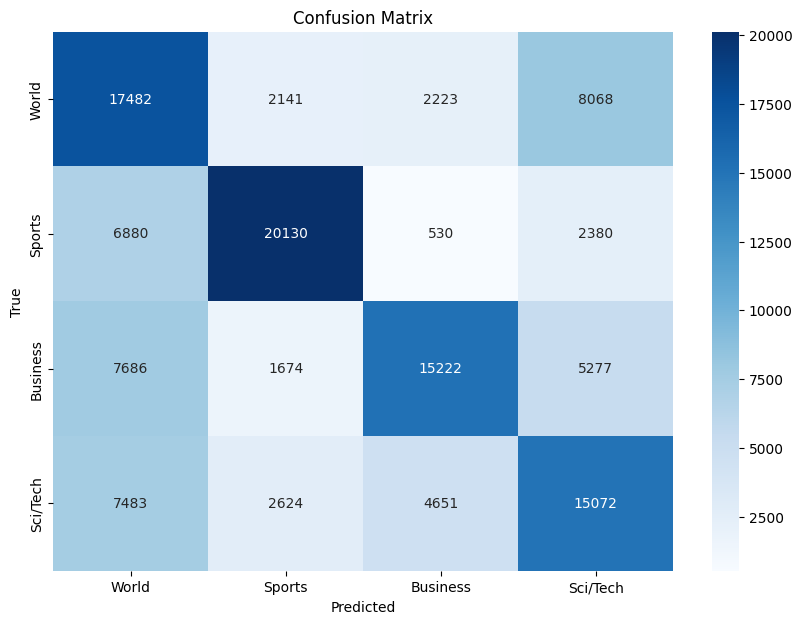

In [24]:
# 生成混淆矩阵
conf_matrix = confusion_matrix(
    df['true_label'],
    df['predicted_label'],
    labels=list(label_map.values())  # 将 dict_values 转换为列表
)

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# 示例输入
sample_input = "The football team won the championship after a thrilling match."

# 预处理示例输入
processed_input = preprocess_text(sample_input)

# 使用关键词匹配模型进行预测
predicted_category = match_keywords(processed_input)

# 输出结果
print(f"Processed Input: {processed_input}")
print(f"Predicted Category: {predicted_category}")

Processed Input: football team championship thrilling match
Predicted Category: Sports
